Importing Libraries & packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from keras.models import Sequential
from IPython.display import display
from PIL import Image
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
import numpy as np
import cv2 as cv
from keras.optimizers import SGD
from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = !unzip "/content/drive/MyDrive/COVID-19_Radiography_Dataset.zip" -d '/content'


In [ ]:
path = "/content/COVID-19_Radiography_Dataset"
labels = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

Mounting drive and reading the data

In [ ]:
data=ImageDataGenerator( rescale = 1./255, validation_split=0.2)
#data=ImageDataGenerator( rescale = 1./255,shear_range= 0.2,  zoom_range= 0.2, horizontal_flip= True, validation_split=0.2)

In [ ]:
training_data=data.flow_from_directory('/content/COVID-19_Radiography_Dataset',target_size = (299,299), batch_size = 32,class_mode = 'categorical', subset='training')
test_data=data.flow_from_directory('/content/COVID-19_Radiography_Dataset',target_size = (299,299), batch_size = 32,class_mode = 'categorical', subset='validation')


Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


Defining Loss function

In [ ]:
def focal_loss(gamma, alpha):
  gamma = float(gamma)
  alpha = float(alpha)
  
  def focal_loss_fixed(y_true, y_pred):
    epsilon = 1.e-9
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
    
    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.math.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)
  return focal_loss_fixed

Transfer learning using VGG 16 by freezing the weights of top 10 layers and adding Dense net as 1024, 512, 128, 32, 16.
Using adam optimizer with learning rate 0.0001 and alpha=0.25,gamma=2.0 for focal loss function.

In [ ]:
model = VGG16()
print(model.summary())

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
my_model = VGG16(weights='imagenet',include_top=False,input_shape=(299,299,3))
last = my_model.output
x=Flatten ()(last)
#x2 = Dense(2048,activation = 'relu')(x)
x3 = Dense(1024,activation = 'relu')(x)
x4 = Dense(512,activation = 'relu')(x3)
x5 = Dense(128,activation = 'relu')(x4)
x6 = Dense(32,activation = 'relu')(x5)
x7 = Dense(16,activation = 'relu')(x6)
my_preds = Dense(4,activation = 'softmax')(x7)
my_model = Model(my_model.input,my_preds)

my_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
______________________________________________________________

In [ ]:
for layers in my_model.layers[:10]:
    layers.trainable = False
for layer in my_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb6620cc210> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb6620ccf90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb6620fa750> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb662163490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb662126150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb6620cfa10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb66215a2d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb662104f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb6620cadd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb6620d7310> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb6621634d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0

In [ ]:
opt = Adam(lr=0.0001)
my_model.compile(optimizer=opt,loss=focal_loss(alpha=0.5,gamma=2.0),metrics=["accuracy"])

In [ ]:
history1 = my_model.fit_generator(training_data, steps_per_epoch=len(training_data) // 40,
                               validation_steps=len(test_data) // 40, validation_data=test_data, epochs=200 ,verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
13/13 - 23s - loss: 0.3369 - accuracy: 0.4736 - val_loss: 0.2964 - val_accuracy: 0.5208
Epoch 2/200
13/13 - 2s - loss: 0.2810 - accuracy: 0.5144 - val_loss: 0.2253 - val_accuracy: 0.5729
Epoch 3/200
13/13 - 2s - loss: 0.2278 - accuracy: 0.6202 - val_loss: 0.2064 - val_accuracy: 0.6771
Epoch 4/200
13/13 - 2s - loss: 0.1761 - accuracy: 0.6803 - val_loss: 0.1922 - val_accuracy: 0.7083
Epoch 5/200
13/13 - 2s - loss: 0.1375 - accuracy: 0.7620 - val_loss: 0.1256 - val_accuracy: 0.7604
Epoch 6/200
13/13 - 2s - loss: 0.1309 - accuracy: 0.7837 - val_loss: 0.1525 - val_accuracy: 0.7708
Epoch 7/200
13/13 - 2s - loss: 0.1058 - accuracy: 0.8173 - val_loss: 0.1140 - val_accuracy: 0.8021
Epoch 8/200
13/13 - 2s - loss: 0.1159 - accuracy: 0.7764 - val_loss: 0.0748 - val_accuracy: 0.8438
Epoch 9/200
13/13 - 2s - loss: 0.1199 - accuracy: 0.7788 - val_loss: 0.1195 - val_accuracy: 0.6979
Epoch 10/200
13/13 - 2s - loss: 0.0926 - accuracy: 0.8149 - val_loss: 0.1069 - val_accuracy: 0.8021
Epoch 11

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


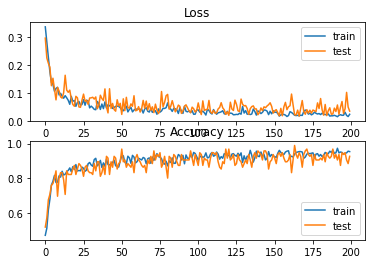

In [ ]:
# evaluate the model

train_acc = my_model.evaluate_generator(training_data, verbose=0)
test_acc =my_model.evaluate_generator(test_data, verbose=0)

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()




# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
test_image,test_label_cols= next(test_data)
predicted_score= my_model.predict(test_image)
predicted_label= predicted_score.argmax(axis=1)
test_label= test_label_cols.argmax(axis=1)
print(confusion_matrix(test_label, predicted_label))

[[ 4  0  1  0]
 [ 0  7  1  0]
 [ 0  0 18  0]
 [ 0  0  0  1]]


In [ ]:
#classification report
labels = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]
from sklearn import metrics
classification_report = metrics.classification_report( test_label, predicted_label,target_names =labels)
print(classification_report)

                 precision    recall  f1-score   support

          COVID       1.00      0.80      0.89         5
         Normal       1.00      0.88      0.93         8
   Lung_Opacity       0.90      1.00      0.95        18
Viral Pneumonia       1.00      1.00      1.00         1

       accuracy                           0.94        32
      macro avg       0.97      0.92      0.94        32
   weighted avg       0.94      0.94      0.94        32



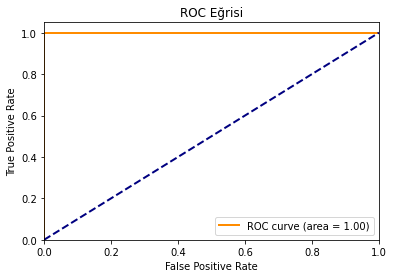

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
test_image,test_label_cols= next(test_data)
y_score= my_model.predict(test_image)

y_test= test_label_cols.argmax(axis=1)

y_test = label_binarize(y_test, classes=[0,1,2,3])
# Learn to predict each class against the other

n_classes = 4 # number of class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], threshold  = roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2 # line_width
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2]) # Drawing Curve according to 2. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':


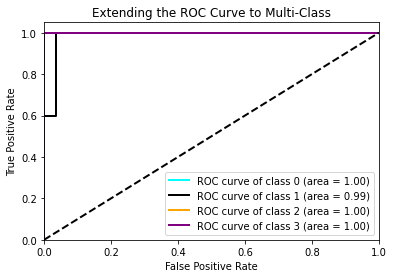

In [ ]:
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
class_names = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

colors = cycle(['aqua', 'black', 'orange','purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()

GRADCAM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm



In [ ]:
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
img_path = "/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png"
img = image.load_img(img_path,target_size=(299,299))
x= image.img_to_array(img)
x=np.expand_dims(x,axis =0)
x=preprocess_input(x)

x_= image.img_to_array(img)
x_=preprocess_input(x_)


In [ ]:
pip install tf-explain

     |████████████████████████████████| 51kB 5.0MB/s 


In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
img_path1 = "/content/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1.png"
img1 = image.load_img(img_path1,target_size=(299,299))
x1= image.img_to_array(img1)
x1=np.expand_dims(x1,axis =0)
x1=preprocess_input(x1)
x1_= image.img_to_array(img1)
x1_=preprocess_input(x1_)

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


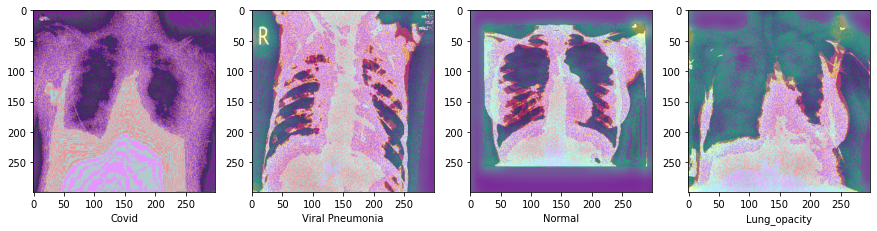

In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
img_path = "/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png"
img = image.load_img(img_path,target_size=(299,299))
x= image.img_to_array(img)
x=np.expand_dims(x,axis =0)
x=preprocess_input(x)

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
img_path2 = "/content/COVID-19_Radiography_Dataset/Normal/Normal-1.png"
img = image.load_img(img_path2,target_size=(299,299))
x2= image.img_to_array(img)
x2=np.expand_dims(x2,axis =0)
x2=preprocess_input(x2)

x2_= image.img_to_array(img)
x2_=preprocess_input(x2_)

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
img_path3 = "/content/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1.png"
img = image.load_img(img_path3,target_size=(299,299))
x3= image.img_to_array(img)
x3=np.expand_dims(x3,axis =0)
x3=preprocess_input(x3)

x3_= image.img_to_array(img)
x3_=preprocess_input(x3_)


from tf_explain.core.grad_cam import GradCAM

explainer = GradCAM()


# visualize GradCAM outputs in Block 1
grid1 = explainer.explain((x, None), my_model,0, layer_name='block4_conv1' )
grid2 = explainer.explain((x1, None), my_model,3,layer_name= 'block4_conv1')
grid3 = explainer.explain((x2, None), my_model,1,layer_name='block4_conv1')
grid4 = explainer.explain((x3, None), my_model,2,layer_name='block4_conv1')
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(1, 4, 1)
plt.xlabel('Covid')

ax1.imshow(x_)
ax1.imshow(grid1, alpha=0.6)
ax2 = fig.add_subplot(1, 4, 2)
plt.xlabel('Viral Pneumonia')
ax2.imshow(x1_)
ax2.imshow(grid2, alpha=0.6)
ax3 = fig.add_subplot(1, 4, 3)
plt.xlabel('Normal')
ax3.imshow(x2_)
ax3.imshow(grid3, alpha=0.6)
ax4 = fig.add_subplot(1, 4, 4)
plt.xlabel('Lung_opacity')
ax4.imshow(x3_ )
ax4.imshow(grid4, alpha=0.6)



In [ ]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.python.framework import ops

In [ ]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(299,299))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x



In [ ]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = my_model
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [ ]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (299, 299), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (299, 299), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [ ]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(0, 3, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [ ]:
model = my_model
guided_model = build_guided_model()

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, img_path = "/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png", layer_name='block5_conv3', cls=0, visualize=True, save=True)
gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, img_path ="/content/COVID-19_Radiography_Dataset/COVID/COVID-1.png", layer_name='block5_conv3',
                                               cls=0, visualize=True, save=False)

ValueError: ignored